# Il Problema del Commesso Viaggiatore Lombardo

In [1]:
%matplotlib inline
import matplotlib.pyplot as pyplot
from gurobipy import *
import numpy
import time

In [2]:
Ps = {}
Ps["BG"]=(9.6772698, 45.6982642)
Ps["BS"]=(10.2118019, 45.5415526)
Ps["CO"]=(9.0851765, 45.8080597)
Ps["CR"]=(10.0226511, 45.133249)
Ps["LC"]=(9.3976704, 45.8565698)
Ps["LO"]=(9.503716, 45.3097228)
Ps["MN"]=(10.7913751, 45.1564168)
Ps["MI"]=(9.1859243, 45.4654219)
Ps["MB"]=(9.276337, 45.581484)
Ps["PV"]=(9.1582069, 45.1847248)
Ps["SO"]=(9.8787674, 46.1698583)
Ps["VA"]=(8.8250576, 45.8205989)

In [3]:
for key in Ps:
    print key, " ==> "+str(Ps[key])

VA  ==> (8.8250576, 45.8205989)
BG  ==> (9.6772698, 45.6982642)
CO  ==> (9.0851765, 45.8080597)
LC  ==> (9.3976704, 45.8565698)
MB  ==> (9.276337, 45.581484)
LO  ==> (9.503716, 45.3097228)
MN  ==> (10.7913751, 45.1564168)
MI  ==> (9.1859243, 45.4654219)
SO  ==> (9.8787674, 46.1698583)
BS  ==> (10.2118019, 45.5415526)
PV  ==> (9.1582069, 45.1847248)
CR  ==> (10.0226511, 45.133249)


In [4]:
def DisegnaPunto(A):
    """
    Disegna un punto nel piano
    """
    pyplot.plot([A[0]], [A[1]], 'bo')

In [5]:
print Ps["PV"]

(9.1582069, 45.1847248)


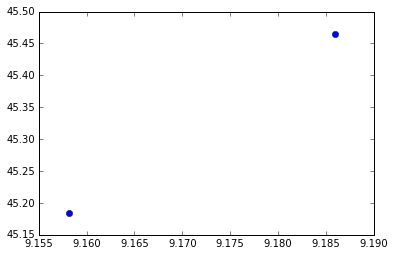

In [6]:
DisegnaPunto(Ps["PV"])
DisegnaPunto(Ps["MI"])

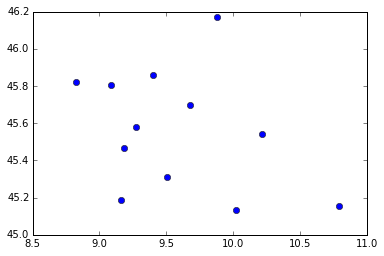

In [7]:
for key in Ps:
    DisegnaPunto(Ps[key])

In [8]:
def DisegnaSegmento(A, B):
    """ 
    Disegna un segmento nel piano dal punto A a al punto B
    Vedi manuale a: http://matplotlib.org/api/pyplot_api.html
    """
    # Disegna il segmento
    pyplot.plot([A[0], B[0]], [A[1], B[1]], 'b')
    # Disegna gli estremi del segmento
    DisegnaPunto(A)
    DisegnaPunto(B)

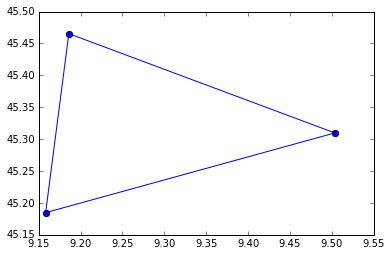

In [9]:
DisegnaSegmento(Ps["PV"], Ps["MI"])
DisegnaSegmento(Ps["MI"], Ps["LO"])
DisegnaSegmento(Ps["LO"], Ps["PV"])

In [10]:
def DisegnaPermutazioneProvincie(Keys, Ps):
    """
    Disegna una permutazione delle provincie come sequenza di segmenti
    """
    for i in range(len(Ps)-1):
        DisegnaSegmento(Ps[Keys[i]], Ps[Keys[i+1]])
    DisegnaSegmento(Ps[Keys[0]], Ps[Keys[-1]])

['PV', 'MB', 'BS', 'BG', 'CO', 'LC', 'CR', 'LO', 'VA', 'SO', 'MI', 'MN']


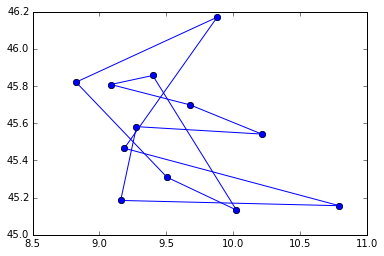

In [11]:
Lista = Ps.keys()
numpy.random.shuffle(Lista)
print Lista
DisegnaPermutazioneProvincie(Lista, Ps)

In [12]:
from haversine import haversine
def CalcolaDistanze():
    """
    Calcola la distanza euclidea (nel piano) tra tutte le coppie di provincie
    """
    D = {}
    for k1 in Ps:
        D[k1] = {}
        for k2 in Ps:
            if k1 != k2:
                #D[k1][k2] = numpy.linalg.norm([Ps[k1], Ps[k2]])
                D[k1][k2] = haversine(Ps[k1], Ps[k2])
    return D

In [13]:
D = CalcolaDistanze()
print D["CO"]["PV"]
print D["LO"]["CO"]

68.9152570597
71.8078089911


In [14]:
tsp_model = Model()

Provincie = Ps.keys()
# Intoduci le variabili del modello
X = {}
for P1 in Provincie:
    X[P1] = {}
    for P2 in D[P1]:
        X[P1][P2] = tsp_model.addVar(vtype=GRB.BINARY, 
                                     obj=D[P1][P2],
                                     name='x_'+P1+'_'+P2)
# Aggiorna il modello
tsp_model.update()

# Aggiungi i vincoli di grado uscente
for i in X:
    expr = LinExpr()
    for j in X[i]:
        expr.add(X[i][j])
    tsp_model.addConstr(expr == 1)

# Aggiungi i vincoli di grado entrante
for i in X:
    expr = LinExpr()
    for j in X[i]:
        expr.add(X[j][i])
    tsp_model.addConstr(expr == 1)

# Aggiungi disuguaglianze triangolari
for i in X:
    for j in X[i]:
        tsp_model.addConstr(X[i][j] + X[j][i] <= 1)
        
for i in X:
    for j in X[i]:
        for h in X[j]:
            if h != i:
                tsp_model.addConstr(X[i][j] + X[j][h] + X[h][i] + X[j][i] + X[h][j] + X[i][h] <= 2)


In [15]:
#tsp_model.setParam(GRB.Param.MIPGap, 0)
#tsp_model.setParam(GRB.Param.MIPGapAbs, 0)
#tsp_model.setParam(GRB.Param.OptimalityTol, 1e-09)

tsp_model.optimize()

Optimize a model with 1476 rows, 132 columns and 8448 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [2e+01, 2e+02]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 2e+00]
Found heuristic solution: objective 1129.93
Presolve removed 1166 rows and 0 columns
Presolve time: 0.02s
Presolved: 310 rows, 132 columns, 1716 nonzeros
Variable types: 0 continuous, 132 integer (132 binary)

Root relaxation: objective 6.021486e+02, 33 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     602.1485754  602.14858  0.00%     -    0s

Explored 0 nodes (33 simplex iterations) in 0.07 seconds
Thread count was 2 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 6.021485753982e+02, best bound 6.021485753982e+02, gap 0.0%


In [16]:
solution = []
cost = 0.0
for i in X:
    for j in X[i]:
        if X[i][j].getAttr('x') > 0.5:
            cost += D[i][j]
            solution += [(i,j)]
print cost, solution

602.148575398 [('VA', 'MB'), ('BG', 'LC'), ('CO', 'VA'), ('LC', 'CO'), ('MB', 'MI'), ('LO', 'CR'), ('MN', 'BS'), ('MI', 'PV'), ('SO', 'BG'), ('BS', 'SO'), ('PV', 'LO'), ('CR', 'MN')]


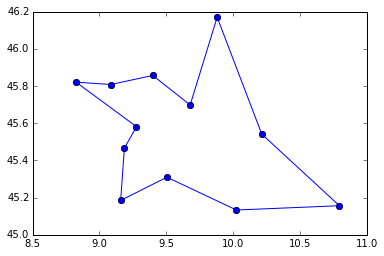

In [17]:
#pyplot.axis('equal')
for (a,b) in solution:
    DisegnaSegmento(Ps[a],Ps[b])

In [18]:
print +D["LO"]["MI"]+D["CR"]["MN"]-D["MI"]["CR"]-D["MN"]["LO"]

-119.309027862


In [19]:
tsp_model.write("tsp.lp")

In [20]:
mysol=[('PV','VA'),('MI','PV'),('VA','CO'),('CO','SO'),('SO','LC'),('LC','BG'),('BG','BS'),('BS','MN'),('MN','CR'),('CR','LO'),('LO','MB'),('MB','MI')]

675.450745425


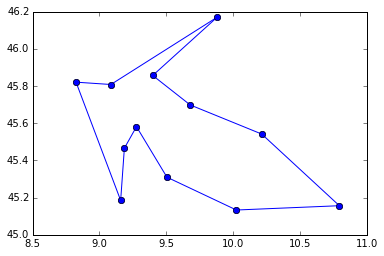

In [21]:
c = 0.0
for (a,b) in mysol:
    c+=D[a][b]
    DisegnaSegmento(Ps[a],Ps[b])
print c

In [22]:
def CycleDetection(Sol, Cities):
    def FindArc(i, Ls):
        for (a,b) in Ls:
            if i == a:
                return (a,b)
    Visited = {}
    for c in Cities:
        Visited[c] = False
        
    (i,j) = Sol[0]
    Visited[i] = True
    Cycle = [(i,j)]
    while not Visited[j]:
        j,h = FindArc(j, Sol)
        Cycle.append((j,h))
        Visited[j] = True
        j = h
    return Cycle

In [23]:
cycle_violated = CycleDetection(solution, Ps.keys())
print cycle_violated

[('VA', 'MB'), ('MB', 'MI'), ('MI', 'PV'), ('PV', 'LO'), ('LO', 'CR'), ('CR', 'MN'), ('MN', 'BS'), ('BS', 'SO'), ('SO', 'BG'), ('BG', 'LC'), ('LC', 'CO'), ('CO', 'VA')]


In [24]:
print Ps.keys()

['VA', 'BG', 'CO', 'LC', 'MB', 'LO', 'MN', 'MI', 'SO', 'BS', 'PV', 'CR']


In [25]:
cut = LinExpr()
for (i,j) in cycle_violated:
    cut.add(X[i][j])
tsp_model.addConstr(cut == len(cycle_violated)-1)
tsp_model.optimize()

Optimize a model with 1477 rows, 132 columns and 8460 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [2e+01, 2e+02]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+01]
Presolve removed 1166 rows and 104 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 4 available processors)

Model is infeasible
Best objective -, best bound -, gap -


In [ ]:
pyplot.axis('equal')
for (a,b) in solution:
    DisegnaSegmento(Ps[a],Ps[b])